This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [1]:
import pandas as pd 
import numpy as np
import random
import datetime as dt

file_name = "./data/data_000637.txt"
data_row = pd.read_csv(file_name)#reading the file to get the number of rows
number_row=len(data_row)#getting the number of rows

print(number_row)
N = random.randint(10001, number_row)#random of N between 10k and the number of rows
print(N)
data = pd.read_csv(file_name,nrows=N)#data is the result
data

1310720
687701


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
687696,1,0,59,3869206894,1799,28
687697,1,0,139,3869206894,1804,0
687698,1,0,62,3869206894,1796,26
687699,1,0,60,3869206894,1802,4


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [2]:
def numberBx(panda_data):
   #result2 = panda_data.groupby(['ORBIT_CNT', 'BX_COUNTER'], as_index=False)['TDC_MEAS'].sum()
    dfa = panda_data.loc[:, ['ORBIT_CNT','BX_COUNTER']]
    dfa = dfa.groupby(['ORBIT_CNT'], as_index=False)['BX_COUNTER'].sum()
    dfa2 =dfa.rename(columns={"BX_COUNTER": "BX_SUM"})
    return dfa2





BX_COUNTER = data["BX_COUNTER"]
BX_value = BX_COUNTER.max()+1

print("The BX in a ORBIT are:",BX_value)

numberBx(data)

The BX in a ORBIT are: 3564


,ORBIT_CNT,BX_SUM
0,3869200167,124133
1,3869200168,97201
2,3869200169,144343
3,3869200170,217462
4,3869200171,228822
...,...,...
6719,3869206890,415919
6720,3869206891,285162
6721,3869206892,369121
6722,3869206893,258861


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [3]:
import datetime as dt

def turn_to_seconds(nano):
    result=nano*(10**-9)
    return result

first_row = data.iloc[0]#Calculation in only the 1st row
#obtaining the sum of nanoseconds from the first row
T_nano = first_row['TDC_MEAS']*25/30 + first_row['BX_COUNTER']*25 + first_row['ORBIT_CNT']*(BX_value+1)*25

#turning nanoSeconds to seconds
T_seconds = turn_to_seconds(T_nano)

total_time=str(dt.timedelta(seconds=T_seconds)).split(".")[0]# Using split to only show seconds


#showing data
print(first_row)
print("\nThe duration of the data of the first row is:")
print(total_time)# 3 days would be another 72 hours

HEAD                    1
FPGA                    0
TDC_CHANNEL           123
ORBIT_CNT      3869200167
BX_COUNTER           2374
TDC_MEAS               26
Name: 0, dtype: int64

The duration of the data of the first row is:
3 days, 23:47:22


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [4]:
#in the previous exercise I already calculated the sum of the 3 columns as T_nano
data['ABSOLUTE_NS'] = (data['TDC_MEAS']*25/30 + data['BX_COUNTER']*25 + data['ORBIT_CNT']*(BX_value+1)*25) - T_nano
#printing data
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_NS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
687696,1,0,59,3869206894,1799,28,5.995295e+08
687697,1,0,139,3869206894,1804,0,5.995296e+08
687698,1,0,62,3869206894,1796,26,5.995294e+08
687699,1,0,60,3869206894,1802,4,5.995296e+08


### 5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [5]:
#Using Group by to get the sum
grouping_by = data.groupby('TDC_CHANNEL').sum()

#Ysing sorted to get the highers values on top
sorted_by=grouping_by.sort_values(by=['HEAD'],ascending=False)

#Selecting the top 3 values
top_three = sorted_by.iloc[:3]

top_three

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_NS
TDC_CHANNEL,,,,,,
139,57085,17083,220873488279635,101925703,0,1.753419e+13
64,34424,750,133193465619383,61735768,503619,1.061166e+13
63,33794,498,130755867488203,60585028,492677,1.043111e+13


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [15]:
Orbits_size = data.groupby('ORBIT_CNT').size().reset_index() #Using groupby to get the non-empty orbits

#renaming the columns
Orbit_counter=Orbits_size.rename(columns={"ORBIT_CNT": "ORBIT_CNT", 0: "COUNTER"})

#1st part, all non-empty orbits
print("The number of non-empty orbits are:\n",len(Orbit_counter))
print(Orbit_counter)
#############
# Getting the TDC_CHANNEL=139
Channel=data['TDC_CHANNEL']==139
#Using size to see the uniques
unique_channel=data[Channel].groupby('ORBIT_CNT').size().reset_index()
#renaming the columns
unique_Orbits=unique_channel.rename(columns={"ORBIT_CNT": "ORBIT_CNT", 0: "COUNTING"})

#Printing the results
print("\nThe number of Unique Orbits that have TDC_CHANNEL=139 :\n",len(unique_Orbits))
unique_Orbits

The number of non-empty orbits are:
 6724
       ORBIT_CNT  COUNTER
0     3869200167       43
1     3869200168       85
2     3869200169      127
3     3869200170       98
4     3869200171      109
...          ...      ...
6719  3869206890      234
6720  3869206891      164
6721  3869206892      199
6722  3869206893      169
6723  3869206894      136

[6724 rows x 2 columns]

The number of Unique Orbits that have TDC_CHANNEL=139 :
 6699


,ORBIT_CNT,COUNTING
0,3869200167,4
1,3869200168,8
2,3869200169,11
3,3869200170,9
4,3869200171,9
...,...,...
6694,3869206890,16
6695,3869206891,11
6696,3869206892,17
6697,3869206893,14


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

,FPGA,COUNTING
0,0,484241
1,1,203460


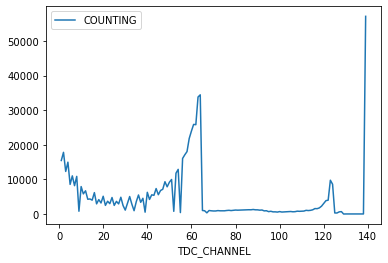

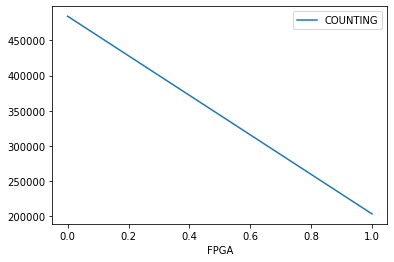

In [22]:
#Plotting for TDC channel,
TDC = data.groupby('TDC_CHANNEL').size().reset_index() #Using groupby to get the non-empty orbits
TDC_Channels=TDC.rename(columns={"TDC_CHANNEL": "TDC_CHANNEL", 0: "COUNTING"})


TDC_Channels.plot(x='TDC_CHANNEL',y='COUNTING')


#Plotting for FPGA

FPGA_count = data.groupby('FPGA').size().reset_index() #Using groupby to get the non-empty orbits
FPGA=FPGA_count.rename(columns={"FPGA": "FPGA", 0: "COUNTING"})


FPGA.plot(x='FPGA',y='COUNTING')
FPGA